## Compare HermiteKAN's ability in function interpolation with MLP

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from HermiteKANLayer import HermiteKANLayer

In [2]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    return y

In [3]:
# Define MLP and HermiteKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.layers(x)


class HermiteKAN(nn.Module):
    def __init__(self):
        super(HermiteKAN, self).__init__()
        self.hermitekan1 = HermiteKANLayer(1, 8, 8)
        self.hermitekan2 = HermiteKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.hermitekan1(x)
        x = self.hermitekan2(x)
        return x

Epoch 1/3000, HermiteKAN Loss: 773.3912, MLP Loss: 0.5711
Epoch 101/3000, HermiteKAN Loss: 3.0517, MLP Loss: 0.1934
Epoch 201/3000, HermiteKAN Loss: 0.7317, MLP Loss: 0.1841
Epoch 301/3000, HermiteKAN Loss: 0.6195, MLP Loss: 0.1826
Epoch 401/3000, HermiteKAN Loss: 0.5599, MLP Loss: 0.1804
Epoch 501/3000, HermiteKAN Loss: 0.5246, MLP Loss: 0.1776
Epoch 601/3000, HermiteKAN Loss: 0.5021, MLP Loss: 0.1741
Epoch 701/3000, HermiteKAN Loss: 0.4871, MLP Loss: 0.3241
Epoch 801/3000, HermiteKAN Loss: 0.4773, MLP Loss: 0.2321
Epoch 901/3000, HermiteKAN Loss: 0.4710, MLP Loss: 0.1970
Epoch 1001/3000, HermiteKAN Loss: 0.4670, MLP Loss: 0.1588
Epoch 1101/3000, HermiteKAN Loss: 0.4645, MLP Loss: 0.1542
Epoch 1201/3000, HermiteKAN Loss: 0.4629, MLP Loss: 0.1497
Epoch 1301/3000, HermiteKAN Loss: 0.4620, MLP Loss: 0.1466
Epoch 1401/3000, HermiteKAN Loss: 0.4613, MLP Loss: 0.1430
Epoch 1501/3000, HermiteKAN Loss: 0.4713, MLP Loss: 0.1680
Epoch 1601/3000, HermiteKAN Loss: 0.5274, MLP Loss: 0.1704
Epoch 1

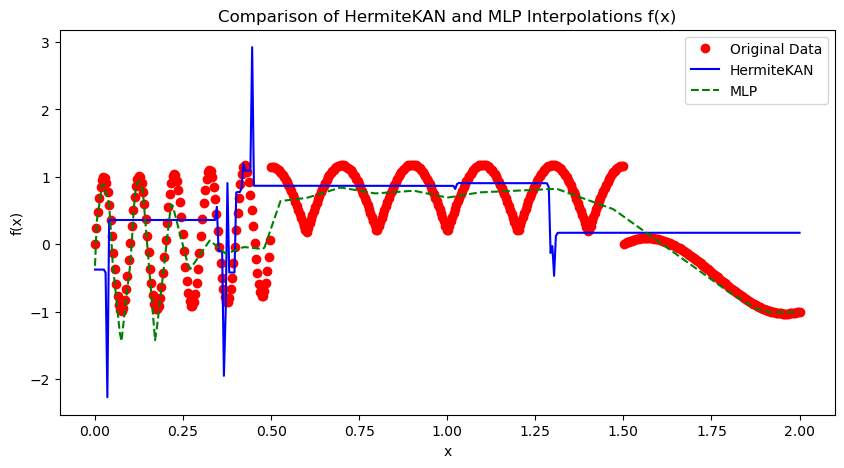

In [4]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
hermite_model = HermiteKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_hermite = torch.optim.Adam(hermite_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

# Train the models
epochs = 3000
for epoch in range(epochs):
    optimizer_hermite.zero_grad()
    outputs_hermite = hermite_model(x_train)
    loss_hermite = criterion(outputs_hermite, y_train)
    loss_hermite.backward()
    optimizer_hermite.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, HermiteKAN Loss: {loss_hermite.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_hermite = hermite_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_hermite.numpy(), 'b-', label='HermiteKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of HermiteKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()